# This is a tutorial on using Word2vec to create a Product Recommendation system. 
https://www.analyticsvidhya.com/blog/2019/07/how-to-build-recommendation-system-word2vec-python/

In [2]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

/Users/xzhao/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
# Read the data
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Here is the description of the fields in this dataset:

InvoiceNo: Invoice number. a unique number assigned to each transaction

StockCode: Product/item code. a unique number assigned to each distinct product

Description: Product description

Quantity: The quantities of each product per transaction

InvoiceDate: Invoice Date and time. The day and time when each transaction was generated

CustomerID: Customer number. a unique number assigned to each customer

In [4]:
df.shape

(541909, 8)

# Clean and Prepare the data

In [5]:
# check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# remove missing values
df.dropna(inplace=True)

In [7]:
# convert stock code to string 
df['StockCode']= df['StockCode'].astype(str)

In [8]:
# check the number of unique customers 
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

There are 4,372 customers in our dataset. For each of these customers, we will extract their buying history. In other words, we can have 4,372 sequences of purchases.

# Create Training and Testing Data (90/10 split)

In [9]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

We will create sequences of purchases made by the customers in the dataset for both the train and validation set.

In [10]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:06<00:00, 649.07it/s]


In [11]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 913.60it/s]


# Train a word2vec model

In [12]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3622124, 3658370)

1. One heuristic is that smaller window sizes (2-15) lead to embeddings where high similarity scores between two embeddings indicates that the words are interchangeable (notice that antonyms are often interchangeable if we’re only looking at their surrounding words – e.g. good and bad often appear in similar contexts). Larger window sizes (15-50, or even more) lead to embeddings where similarity is more indicative of relatedness of the words.

2. The number of negative samples is another factor of the training process. The original paper prescribes 5-20 as being a good number of negative samples. It also states that 2-5 seems to be enough when you have a large enough dataset.

In [13]:
# since we are done training the model, we can make it more memory efficient. 
model.init_sims(replace=True)

In [14]:
print(model)

Word2Vec(vocab=3163, vector_size=100, alpha=0.03)


Visualizing Word2Vec Embeddings using UMAP dimensionality reductions from 100 dim to 2 dim. 

In [22]:
# extract all vectors
X = model.wv.get_normed_vectors()

X.shape

(3163, 100)

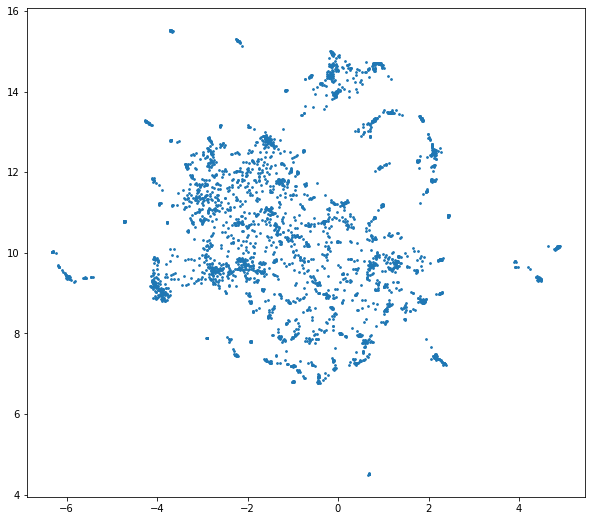

In [23]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

Every dot in this plot is a product. As you can see, there are several tiny clusters of these data points. These are groups of similar products.

# Start of Product Recommendation 

Now, our next step is to suggest similar products for a certain product or a product’s vector.

first create a product-ID and product-description dictionary to easily map a product’s description to its ID and vice versa.

In [25]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [26]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

The function below will take a product’s vector (n) as input and return top 6 similar products:

In [31]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.wv.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms  

try out our function by passing the vector of the product ‘90019A’ (‘SILVER M.O.P ORBIT BRACELET’):

In [32]:
similar_products(model.wv['90019A'])

[('PINK BOUDICCA LARGE BRACELET', 0.7623582482337952),
 ('PINK HEART OF GLASS BRACELET', 0.7491743564605713),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.7099161744117737),
 ('BLACK VINTAGE  CRYSTAL EARRINGS', 0.7031257152557373),
 ('ANT COPPER RED BOUDICCA BRACELET', 0.702298641204834),
 ('BLUE MURANO TWIST BRACELET', 0.7018544673919678)]

this output is based on the vector of a single product only, which is what we want for phase 1. 


For Phase 2, If we want to recommend products based on the multiple purchases he or she has made in the past?

One simple solution is to take the average of all the vectors of the products the user has bought so far and use this resultant vector to find similar products. We will use the function below that takes in a list of product IDs and gives out a 100-dimensional vector which is a mean of vectors of the products in the input list:

In [42]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

Recall that we have already created a separate list of purchase sequences for validation purposes. Now let’s make use of that.

In [43]:
len(purchases_val[0])

196

The length of the first list of products purchased by a user is 196. We will pass this products’ sequence of the validation set to the function aggregate_vectors.

In [44]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [45]:
similar_products(aggregate_vectors(purchases_val[0]))

[('SET OF 3 CAKE TINS PANTRY DESIGN ', 0.6984906196594238),
 ('JAM MAKING SET PRINTED', 0.6798282861709595),
 ('SPOTTY BUNTING', 0.6722570657730103),
 ('JAM MAKING SET WITH JARS', 0.6687036156654358),
 ('SET OF 3 REGENCY CAKE TINS', 0.6677337884902954),
 ('SET OF TEA COFFEE SUGAR TINS PANTRY', 0.6665714979171753)]

Our system has recommended 6 products based on the entire purchase history of a user. Moreover, if you want to get product suggestions based on the last few purchases, only then also you can use the same set of functions.

Below is the code that allows us to make a recomomendation based on the last 10 (most recent) products the user bought. 

In [46]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('SET OF 3 REGENCY CAKE TINS', 0.6535059809684753),
 ('PACK OF SIX LED TEA LIGHTS', 0.650452733039856),
 ('VINTAGE CHRISTMAS STOCKING ', 0.6474653482437134),
 ('SET OF 20 VINTAGE CHRISTMAS NAPKINS', 0.6433941125869751),
 ("PAPER CHAIN KIT 50'S CHRISTMAS ", 0.6275955438613892),
 ('BISCUIT TIN VINTAGE CHRISTMAS', 0.619895339012146)]